In [133]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import pandas as pd
import seaborn as sns
import numpy as np
import gseapy as gp
import re
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from plotting_utils import label_sample, figure_path
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)
colors = okabeito_palette()
colors.append('black')


def count_to_tpm(count, length):
    rate = count/length
    tpm = rate/rate.sum() * 1e6 
    return tpm


def rename_longRNA(name):
    try:
        x = name.split('_')[1]
        treatment = ''
    
        is_long = 0
        if 'Frag' in x:
            treatment = 'Fragmented'
            is_long = 1
        elif re.search('L[12]', x):
            treatment = 'PolyA-selected'
            is_long = 1
        elif re.search('Qcf[0-9]+|SS|DNase',name):
            treatment = 'DNase I'
            is_long = 0
        elif re.search('[Pp]hos', name):
            treatment = 'DNase I + phosphatase'
            is_long = 0
            
        if is_long == 1:
            return treatment +' ' + re.search('\d+', x).group(0)
        else:
            return treatment 
    except IndexError:
        return name

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
count_file = project_path + '/Counts/combined_gene_count.tsv'

count_df = pd.read_table(count_file) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type)) \
    .assign(DNase_1 = lambda d: d.filter(regex='Q[cC][fF][0-9]+').sum(axis=1))
count_df.head()

,id,grouped_type,type,name,IGG_cf_R1_001,QCF1_R1_001,QCF2_R1_001,Qcf10_R1_001,Qcf11_R1_001,Qcf4_R1_001,...,Qcf_LE1_R1_001,Qcf_NA2_R1_001,Qcf_NA3_R1_001,Qcf_NA4_R1_001,Qcf_Na1_R1_001,Qcf_Phos1_R1_001,S96_cfD_R1_001,S96_cf_R1_001,genome_sim_R1_001,DNase_1
0,18S_rRNA,rRNA,rDNA,18S_rRNA,900.5,87760.0,135395.5,36359.5,131824.5,121554.0,...,108.0,1023.5,1392.0,1275.0,1013.5,1698652.0,52462.0,56256.5,126.0,839799.5
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1385.5,192404.0,272497.5,76302.0,297211.0,305133.0,...,838.5,1983.5,3062.0,2672.5,2174.5,2971906.0,138076.0,147620.0,266.5,1913728.5
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,217.5,83417.0,76761.0,48814.5,215957.5,254594.5,...,457.5,121.5,398.0,361.5,159.5,143294.5,181092.5,193161.0,12.5,1266894.0
3,5S_rRNA,rRNA,rDNA,5S_rRNA,4.0,112836.0,123751.0,36413.5,152188.0,103664.5,...,0.5,57.5,225.5,189.0,85.0,69686.5,1675.5,1770.5,108.0,820792.0
4,ENSG00000000003.14_2,Protein coding,protein_coding,TSPAN6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,29.0,36.0,11.0,0.0,0.0,0.0,211.0,1.0


In [135]:
gene_length = pd.read_table('/stor/work/Lambowitz/ref/hg19/genome/genes.length', 
                            names = ['id','glength'])
gene_length.head()

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ|DNa') \
    .query('grouped_type == "Protein coding"')\
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .merge(gene_length)  
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.head()

,id,grouped_type,type,name,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,DNase_1,glength
0,ENSG00000000003,Protein coding,protein_coding,TSPAN6,28.509875,20.841331,11.510668,1.146028,0.236566,1.0,11321
1,ENSG00000000005,Protein coding,protein_coding,TNMD,11.672152,17.381210,13.823486,0.286729,0.355124,1.0,15083
2,ENSG00000000419,Protein coding,protein_coding,DPM1,14.864157,7.747068,6.601432,6.572533,1.582841,4.0,23688
3,ENSG00000000457,Protein coding,protein_coding,SCYL3,15.776599,11.746608,18.392493,1.162665,0.240001,6.0,44636
4,ENSG00000000460,Protein coding,protein_coding,C1orf112,20.939246,13.655915,14.051048,6.037353,0.725428,19.0,191976


In [136]:
def read_platelet():
    d = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/platelets/platelet/quant.genes.sf'
    return pd.read_table(d) \
        .filter(['Name','TPM'])\
        .rename(columns = {"Name":'Gene',
                          'TPM':'platelet'}) \
        .assign(Gene = lambda d: d.Gene.str.split('.',expand=True).iloc[:, 0])

gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr) \
    .pipe(pd.pivot_table, index=['Gene','Gene name'],columns="Sample", values='Value')\
    .merge(read_platelet(), on = 'Gene') \
    .pipe(pd.melt, id_vars = 'Gene', var_name = 'Sample', value_name = 'Value')
expr_df.head()

,Gene,Sample,Value
0,ENSG00000000003,adipose tissue,31.5
1,ENSG00000000005,adipose tissue,10.1
2,ENSG00000000419,adipose tissue,45.6
3,ENSG00000000457,adipose tissue,5.7
4,ENSG00000000460,adipose tissue,2.0


In [137]:
top_n = 80
tpm_cor_df = tpm_df\
    .filter(regex='id|Frag|L[12]')\
    .rename(columns = {'id':'Gene'})
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_cor_df, on ='Gene', how ='inner')\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .iloc[:, 1:]\
    .transform(lambda x: np.log(x+1))\
    .corr(method = 'pearson')\
    .filter(regex = 'Qcf|Frag') \
    .reset_index() \
    .pipe(lambda d: d[~d['index'].str.contains('Qcf')])\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(top_n)
cor_df.index = cor_df['index']
cor_df

,index,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
index,,,,,,
bone marrow,bone marrow,0.131160,0.157900,0.143612,0.538196,0.545941
lymph node,lymph node,0.114303,0.147163,0.138276,0.494106,0.491961
spleen,spleen,0.128920,0.158915,0.145421,0.492320,0.491132
appendix,appendix,0.126548,0.161398,0.144604,0.487029,0.486811
tonsil,tonsil,0.104536,0.140618,0.136603,0.482303,0.477978
platelet,platelet,0.177297,0.184859,0.162381,0.466318,0.479341
salivary gland,salivary gland,0.144978,0.162432,0.153153,0.462682,0.479063
adipose tissue,adipose tissue,0.129223,0.160128,0.146061,0.461754,0.461410
colon,colon,0.122365,0.154892,0.146605,0.461212,0.468009


In [128]:
def plot_heatmap_tissue(cor_df, regex='L[12]', figurename = None):
    fig = plt.figure(figsize = (10,3))
    ax = fig.add_subplot(111)
    plot_df = cor_df.filter(regex = regex)\
                .pipe(lambda d: d.sort_values(d.columns[0], ascending=False))\
                .rename(columns = rename_longRNA)\
                .transpose()
    sns.heatmap(plot_df,
           cmap = 'viridis', ax = ax)
    ax.set_ylabel('Sample')
    ax.set_xlabel('Primary tissue')
    xt = ax.set_xticks(np.arange(plot_df.shape[1])+0.5)
    xt = ax.set_xticklabels(plot_df.columns.str.capitalize(), fontsize=14, 
                        rotation=70, rotation_mode='anchor', ha ='right')
    for xt in ax.get_xticklabels():
        if re.search('one marrow|ymph node|pleen|latelet', xt.get_text()):
            xt.set_color('#72624a')
        else:
            xt.set_color('#adaba9')
        xt.set_text(xt.get_text().capitalize())
    fig.text(0.86,0.7, r"Spearman's $\rho$", rotation = 270, fontsize=15)
    fig.savefig(figurename, bbox_inches='tight')
    print('Saved:', figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/tissue_heatmap.pdf


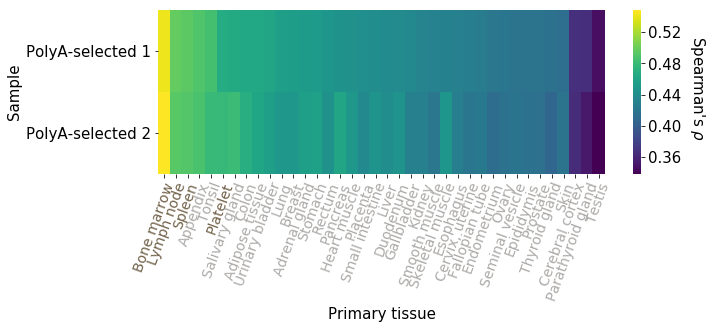

In [129]:
figurename = figure_path + '/tissue_heatmap.pdf'
plot_heatmap_tissue(cor_df, regex='L[12]', figurename = figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/tissue_heatmap_frag.pdf


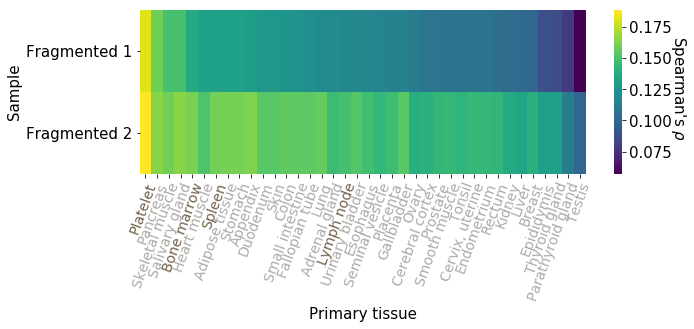

In [130]:
figurename = figure_path + '/tissue_heatmap_frag.pdf'
plot_heatmap_tissue(cor_df, regex='Frag', figurename = figurename)

In [111]:
colors = ['red','darkgreen','chocolate','purple4','gold','khaki',
          'brown','pink','steelblue','skyblue','darkgrey']
tissues_order = ["Abdominal" ,'Brain',"Breast/Female Reproductive","Lung","Lymphoid", 
                 "Myeloid","Sarcoma", "Skin", "Urinary/Male Reproductive" ,
                 "Primary Tissue",'Other']

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


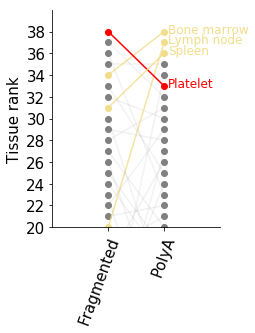

In [132]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
for tissue, row in cor_df \
        .filter(regex='Frag2|L1') \
        .reset_index()\
        .pipe(pd.melt, id_vars = 'index') \
        .assign(x = lambda d: np.where(d.variable.str.contains('Frag'), 1, 2))\
        .assign(rank = lambda d: d.groupby(['x','variable'])['value'].rank(ascending=True))\
        .pipe(pd.pivot_table, columns='variable', values='rank', index='index')\
        .iterrows():
    color = 'gray'
    alpha = 0.1
    if re.search('bone marrow|lymph node|spleen', tissue):
        color = '#f2dd8c'
        alpha = 0.8
    elif re.search('platelet', tissue):
        color = 'red'
        alpha = 1
        
    if color != "gray":
        ax.text(2+0.07, row['Qcf_L1_R1_001']-0.1, tissue.capitalize(), ha = 'left',
                color = color, size = 12)
    ax.scatter([1,2], 
             [row['Qcf_Frag2_R1_001'], row['Qcf_L1_R1_001']], 
            color=color, alpha=1)
    ax.plot([1,2], 
             [row['Qcf_Frag2_R1_001'], row['Qcf_L1_R1_001']], 
            color=color, alpha=alpha)
ax.set_ylabel('Tissue rank')
ax.set_xlim(0,3)
ax.set_xticks([1,2])
ax.set_xticklabels(['Fragmented','PolyA'], 
                   rotation=70, ha = 'right', rotation_mode='anchor')
ax.set_ylim(20,40)
ax.set_yticks(range(20,40,2))
ax.set_yticklabels(range(20,40,2))
ax.set_xlabel('')
sns.despine()
fig.savefig(figure_path + '/correlation_change.pdf',
           bbox_inches='tight')

In [7]:
def plot_heatmap(ax, sort_column, ylab=False):
    top_n = 50
    hd = tpm_df\
        .query('type == "protein_coding"')\
        .pipe(lambda d: d[~d.name.str.contains('^MT')]) \
        .set_index('name') \
        .rename(columns = rename_longRNA) \
        .filter(regex = 'Poly|Frag|DN')\
        .nlargest(top_n, sort_column) \
        .transform(lambda x: np.log2(x + 1))

    sns.heatmap(hd, cmap='viridis', ax = ax)
    yt = ax.set_yticks(np.arange(top_n) +0.5)
    yt = ax.set_yticklabels(hd.index[:top_n], fontsize = 12)
    if ylab:
        ax.set_ylabel('Protein-coding genes')
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation = 70,
                       ha='right',
                       rotation_mode = 'anchor')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/protein_heatmap.pdf


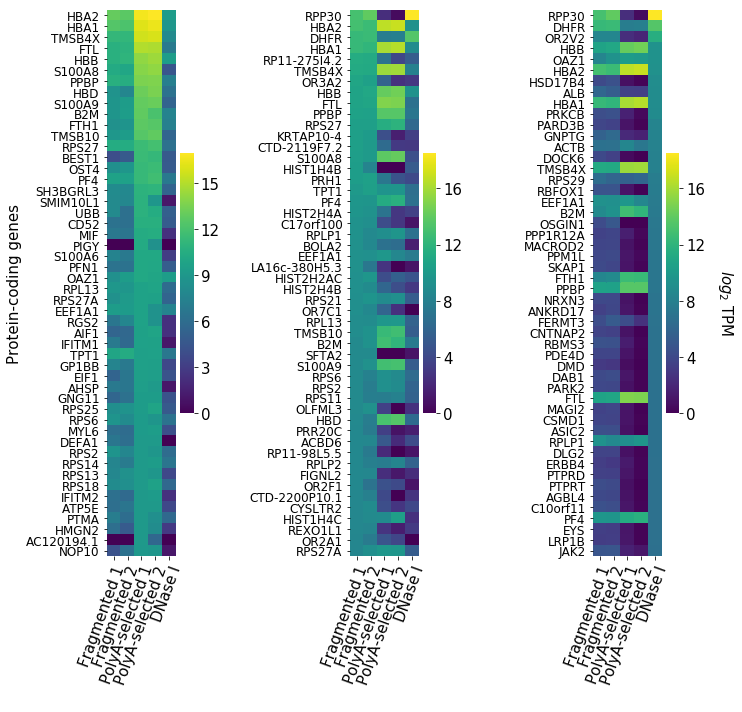

In [8]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


plot_heatmap(ax, 'PolyA-selected 1', ylab=True)
plot_heatmap(ax2, 'Fragmented 1')
plot_heatmap(ax3, 'DNase I')
fig.tight_layout()
fig.text(1,0.6, r"$log_2$ TPM", rotation = 270, fontsize=15)
figure_name = figure_path + '/protein_heatmap.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved %s' %figure_name)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/all_long_rna.pdf


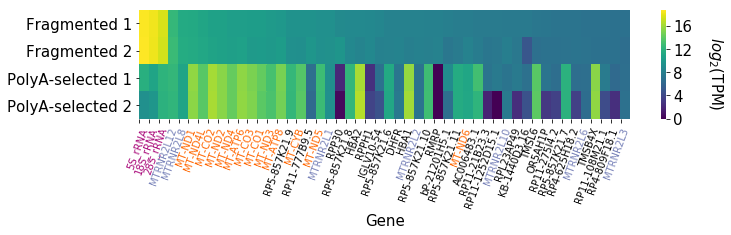

In [9]:
top_n = 50

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ|DNa') \
    .pipe(lambda d: d[~d.grouped_type.str.contains('tRNA|snRNA|snoRNA|snc')])\
    .pipe(lambda d: d[~d.name.str.contains('RNU')])\
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .merge(gene_length)  
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])

all_heat_df = tpm_df\
    .nlargest(top_n,'Qcf_Frag1_R1_001')\
    .set_index('name')\
    .filter(regex = 'Qc') \
    .transform(lambda x: np.log2(x+1))\
    .rename(columns = rename_longRNA)\
    .transpose() 

fig = plt.figure(figsize = (11,2))
ax = fig.add_subplot(111)
sns.heatmap(all_heat_df, ax = ax, 
            cmap = 'viridis')
ax.set_xticks(np.arange(top_n))
xt = ax.set_xticklabels(all_heat_df.columns, rotation = 70,
                   fontsize=10, rotation_mode = 'anchor', ha = 'right')
for xt in ax.get_xticklabels():
    if 'MTRNR2L' in xt.get_text():
        xt.set_color('#7a84ba')
    elif 'MT' in xt.get_text():
        xt.set_color('#ff6600')
    elif 'rRNA' in xt.get_text():
        xt.set_color('#aa0b7b')
ax.set_xlabel('Gene')
fig.text(0.84, 0.6, '$log_2$(TPM)', rotation = 270, fontsize=15)
figurename = figure_path + '/all_long_rna.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Saved:', figurename)

In [86]:
def plot_quantile_group(ax, qcut_expr_df):
    colors = simpsons_palette()
    for col, (gl, gl_df) in zip(colors, qcut_expr_df.groupby('ntile')):
        sns.distplot(np.log2(gl_df.glength), 
                 ax = ax, 
                 color = col,
                 label = gl,
                hist=False)
    ax.set_xlabel('Gene length')
    ax.set_ylabel('Density')
    ax.legend(fontsize=15, frameon=False).set_visible(False)
    sns.despine()
    
    
def plot_cor_quantile(ax, expr_df, tpm_df):
    qcut_expr_df = expr_df\
        .pipe(pd.pivot_table, columns = 'Sample', 
              index=['Gene'], values='Value') \
        .reset_index() \
        .merge(tpm_df.rename(columns = {'id':'Gene'}), 
                on ='Gene', how ='inner') \
        .filter(regex = 'name|glength|Gene|L1|bone marrow') \
        .assign(ntile = lambda d: pd.qcut(d.glength, 10, labels=False))\
        .assign(ntile = lambda d: d.ntile.astype(str))
    
    qcut_expr_df.filter(regex = 'ntile|bone|Qc')\
        .reset_index()\
        .groupby('ntile', as_index=False)\
        .apply(cor_ntile) \
        .set_index('ntile')\
        .transpose()\
        .plot.bar( ax = ax, colors = simpsons_palette())
    lgd = ax.legend(bbox_to_anchor = (1,1), title='Quantile\ngene\ngroup', 
                    frameon=False, fontsize=15)
    lgd =plt.setp(lgd.get_title(),fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation =70, rotation_mode = 'anchor', ha = 'right')
    ax.set_xlabel('Distance function')
    ax.set_ylabel(r"Coefficient"\
              ' between\nBone marrow (published) and\nPlasma (polyA-selected)')
    sns.despine()
    return qcut_expr_df
        
        
def cor_ntile(d):
    x = np.log(d['bone marrow']+1)
    y = np.log(d['Qcf_L1_R1_001']+1)
    spearman_r, _ = spearmanr(x, y)
    pearson_r, _ = pearsonr(x, y)
    cosine_sim = cosine_similarity(x.values.reshape(1,-1), y.values.reshape(1,-1))
    #cor_coef = d.filter(regex = 'bone|Qc').corr(method='spearman')
    #cor_coef = cor_coef.iloc[0,1]
    return pd.DataFrame({'ntile':[d.ntile.unique()[0]],
                        "Spearman's\ncorrelation":[spearman_r],
                         "Pearson's\ncorrelation":[pearson_r],
                        'Cosine\nsimilarity':[cosine_sim[0][0]]})

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/quantile_plot.pdf


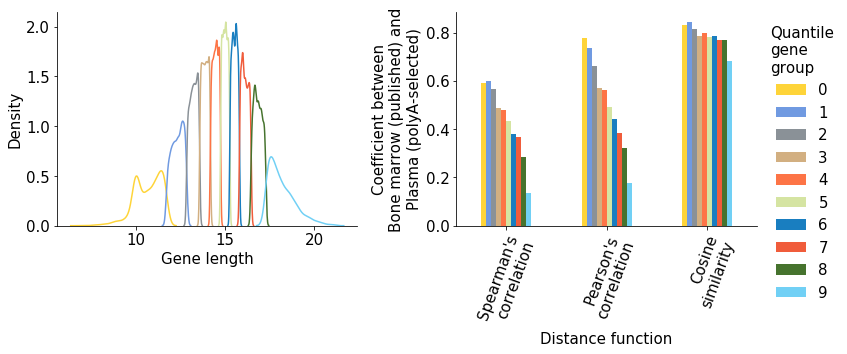

In [87]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(122)
qcut_expr_df = plot_cor_quantile(ax, expr_df, tpm_df)

ax=fig.add_subplot(121)
plot_quantile_group(ax, qcut_expr_df)
fig.tight_layout()
figurename = figure_path + '/quantile_plot.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Saved:', figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/scatter_cosine.png


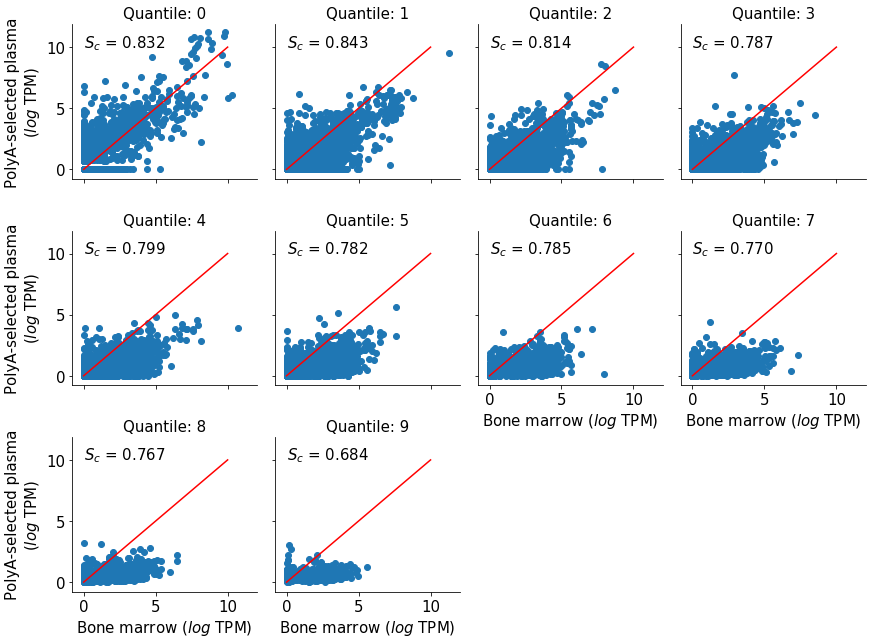

In [69]:
from scipy.stats import pearsonr

plot_qcut = qcut_expr_df\
            .assign(plasma = lambda d: d['Qcf_L1_R1_001'].transform(lambda x: np.log(x+1)))\
            .assign(bone = lambda d: d['bone marrow'].transform(lambda x: np.log(x+1)))\
            .sort_values('ntile')
p = sns.FacetGrid(data = plot_qcut, 
                  col = 'ntile', col_wrap = 4)
p.map(plt.scatter, 'bone', 'plasma')
p.set_titles('Quantile: {col_name}')
p.set_axis_labels('Bone marrow ($log$ TPM)', 'PolyA-selected plasma\n($log$ TPM)')

for ax in p.fig.axes:
    ax.plot([0,10],[0,10], color='red')
    
    data = plot_qcut.query("ntile == '%s'" %(ax.title.get_text().split(' ')[1]))
    cor_coef = cosine_similarity(data['plasma'].values.reshape(1,-1), 
                                       data['bone'].values.reshape(1,-1))
    ax.text(0, 10, r'$S_c$ = %.3f' %cor_coef, fontsize=15)
    
    
figurename = figure_path + '/scatter_cosine.png'
p.savefig(figurename, bbox_inches = 'tight')
print('Saved:', figurename)

In [26]:
','.join(count_df.sort_values('QCF1_R1_001', ascending=False).query('grouped_type == "Protein coding"').name[:100])

'RPP30,DHFR,MTRNR2L12,MTRNR2L8,LLfos-48D6.2,OAZ1,MT-ND4,MT-CO1,MT-ND2,MT-ND1,HSD17B4,HBA2,HBB,MT-ATP6,HBA1,MT-ND5,MT-CO3,MT-CO2,GNPTG,MT-CYB,DOCK6,MTRNR2L1,MT-ND4L,RPS29,ACTB,OSGIN1,RBFOX1,TMSB4X,MT-ATP8,B2M,PARD3B,PRKCB,MT-ND3,PPBP,FTH1,MYH9,DAB1,PF4,OPCML,CTNNA2,MACROD2,ATRNL1,NKAIN2,DMD,EYS,MAGI2,NRXN3,SOX5,CAMTA1,PTPRD,ROBO2,MTRNR2L10,HBD,FTL,PARK2,CNTNAP2,NPAS3,SPAG16,MYT1L,SCAP,LRP1B,TRAK2,MT-ND6,NAV3,ASIC2,C10orf11,EEF1A1,PTPRN2,SUMF1,NRG3,ERC2,PLCB1,NRGN,ADGRB3,DLG2,DPP6,EEF1G,PTPRM,NRG1,WWOX,ODZ4,CSNK1D,RP11-864I4.1,ANKS1B,LARGE,TLN1,NLGN1,SMARCA2,NTRK3,ROBO1,SLC24A3,SKAP1,EPHB1,IQSEC3,SLC30A10,SLC27A6,SYN3,SPTBN1,LSAMP,PTPRT'